<h1 style="color:red;"> Capstone Project: Battle of Neighborhoods</h1>

### Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ol>
    <li><a href="#1.-Introduction---Business-Problem">Introduction - Business Problem</a>        
    <li><a href="#2.Data">Data</a>        
    <li><a href="#3.-Methodology">Methodology</a>
</ol>
</div>

<h2 style="color:blue;">1. <u>Introduction - Business Problem</u> </h2>
<h3>Opening a Yoga Studio</h3>

<i>I want to open a new Yoga Studio in Toronto. Where should I open it? </i>
This is one of the questions that an entrepreneur would need to answer before starting his or her yoga studio. Location is key for a new business and one that requires careful research. In this capstone project, I will attempt to solve this problem through data analysis.

<h2 style="color:blue;">2.<u>Data</u></h2>

To solve the problem, we will need the following data : 
<ul>
    <li><b>Toronto Neighborhood data</b> which we already have from previous assignments
    <li><b>Foursquare yoga venues data</b>: for each neighborhood, we will be running an API call to pull all the yoga venues within 5km of the geographical coordinates provided in the Toronto Neighborhood data</li>
    <li><b>Foursquare nearby venues data</b> we will need to pull the venues that surrounds the yoga venue for pattern analysis</li>
  

### Toronto Neighborhood Data 
In this section we will be building the Neighborhood data profile which consists of the Neighborhood name, Borough name, Postal Code, Latitude and Longitude

In [78]:
import pandas as pd
import numpy as np
import wget
import requests
import csv
import geocoder
import geopy
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import json 
import matplotlib.pyplot as plt
print("Libraries imported")

Libraries imported


#### Data Cleaning and Wrangling

We will use the data from the previous assignment to retrieve the zip codes and then the geolocation data for each neighborhood. We will not use Borough in this section

In [2]:
#let's open the csv file
csvfile = "C:/Users/nirin/Downloads/output.csv"
neighpostal = pd.read_csv(csvfile,
                 header=0,
                 delimiter='  ',                 
                 quotechar='"',
                 error_bad_lines=False,
                 engine='python')
neighpostal.shape

(180, 3)

In [3]:
neighpostal.drop(neighpostal[neighpostal['Borough'] =='Not assigned'].index, inplace = True)
print("removed rows with Not assigned Borough")

removed rows with Not assigned Borough


In [4]:
neighpostal.shape

(103, 3)

Next we will need to pull the Latitude and Longitude data which are stored in the Geospatial coordinates file

In [6]:
#Importing the geographical data
geodf = pd.read_csv("C:/Users/nirin/Geospatial_Coordinates.csv",                   
                 header=0,
                 delimiter=",",                 
                 error_bad_lines=False,
                 engine='python'
                   )
geodf.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

Now let's merge the two dataframe to obtain the desired data

In [7]:
dfmerge = neighpostal.merge(geodf)
dfmerge.rename(columns = {'Neighbourhood' : 'Neighborhood' }, inplace = True)
dfmerge.tail(5)

Postal Code           Borough  \
98          M8X         Etobicoke   
99          M4Y  Downtown Toronto   
100         M7Y      East Toronto   
101         M8Y         Etobicoke   
102         M8Z         Etobicoke   

                                         Neighbourhood   Latitude  Longitude  
98   The Kingsway,Montgomery Road,Old Mill North,Ki...  43.653654 -79.506944  
99                                Church and Wellesley  43.665860 -79.383160  
100  Business reply mail Processing Centre,South Ce...  43.662744 -79.321558  
101  Old Mill South,King's Mill Park,Sunnylea,Humbe...  43.636258 -79.498509  
102  Mimico NW,The Queensway West,South of Bloor,Ki...  43.628841 -79.520999

It looks like the data is still grouped by Borough, let's change it so that each unique Neighbourhood is in it's own row

In [10]:
dfmerge['Neighborhood'] = dfmerge['Neighborhood'].str.split(',')

In [11]:
dfmerge = dfmerge.explode('Neighborhood')
dfmerge.shape

(304, 5)

We have our first dataframe!

## Building the Yoga Venues data using Foursquare API

In this section, let's use the Foursquare API to get a list of the yoga studios around toronto for each neighborhood

In [13]:
import random # library for random number generation
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

In [14]:
CLIENT_ID = 'NGBR4FWG0IAT0DHXIBKYXI2E1JI2LEJMEL3L1YA1RW4CSLXG'
CLIENT_SECRET = '23BDE00ECXWL0IEIDFLXDMQIK0PERQTG1MSKSKUOGBPAQSRJ' 
VERSION = '20180323'
#VERSION = '20190425'
LIMIT = 20
print('My credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentials:
CLIENT_ID: NGBR4FWG0IAT0DHXIBKYXI2E1JI2LEJMEL3L1YA1RW4CSLXG
CLIENT_SECRET:23BDE00ECXWL0IEIDFLXDMQIK0PERQTG1MSKSKUOGBPAQSRJ


In [15]:
query = 'yoga class'
radius = 500
neighb = 'Annex'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(neighb)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

43.6703377 -79.407117


Let's create a function that iterates through all the neighborhood and runs an API call against each row in the dataframe

In [20]:
def getYogaStudios(names, latitudes, longitudes, radius=5000):
    
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):     
                
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query=yoga class&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
          
        # make the GET request        
        results = requests.get(url).json()['response']['groups'][0]['items']
        print(results)                
            
            
        # return only relevant information for each nearby venue    
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results])
        
        #Create the dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude']
    print("Dataframe Created")    
    return(nearby_venues)

In [21]:
query_results = getYogaStudios(names = dfmerge['Neighborhood'],
                                  latitudes = dfmerge['Latitude'],
                                   longitudes = dfmerge['Longitude']
                                  )

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c18e819d4d9c9284e19f029', 'name': 'LA Fitness', 'contact': {}, 'location': {'address': '1380 Don Mills Road', 'crossStreet': 'Mallard Rd', 'lat': 43.74766522888878, 'lng': -79.34707696065234, 'labeledLatLngs': [{'label': 'display', 'lat': 43.74766522888878, 'lng': -79.34707696065234}], 'distance': 1532, 'postalCode': 'M3B 2X2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1380 Don Mills Road (Mallard Rd)', 'Toronto ON M3B 2X2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d176941735', 'name': 'Gym', 'pluralName': 'Gyms', 'shortName': 'Gym', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExp

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 2888, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 2888, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 2888, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 2888, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c0077d4df6c0f47747c8b22', 'name': 'Bikram Yoga Forest Hill', 'contact': {}, 'location': {'address': '1059 Eglinton Ave W', 'lat': 43.69779782018834, 'lng': -79.44029755187503, 'labeledLatLngs': [{'label': 'display', 'lat': 43.69779782018834, 'lng': -79.44029755187503}], 'distance': 3032, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1059 Eglinton Ave W', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 2645, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 2914, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 2914, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[]
[]
[]
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c18e819d4d9c9284e19f029', 'name': 'LA Fitness', 'contact': {}, 'location': {'address': '1380 Don Mills Road', 'crossStreet': 'Mallard Rd', 'lat': 43.74766522888878, 'lng': -79.34707696065234, 'labeledLatLngs': [{'label': 'display', 'lat': 43.74766522888878, 'lng': -79.34707696065234}], 'distance': 455, 'postalCode': 'M3B 2X2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1380 Don Mills Road (Mallard Rd)', 'Toronto ON M3B 2X2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d176941735', 'name': 'Gym', 'pluralName': 'Gyms', 'shortName': 'Gym', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCh

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b677c35f964a520c7512be3', 'name': 'Moksha Yoga Danforth', 'contact': {}, 'location': {'address': '372 Danforth Ave', 'crossStreet': 'at Chester Ave', 'lat': 43.67762174479883, 'lng': -79.3521159367257, 'labeledLatLngs': [{'label': 'display', 'lat': 43.67762174479883, 'lng': -79.3521159367257}], 'distance': 4667, 'postalCode': 'M4K 1N8', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['372 Danforth Ave (at Chester Ave)', 'Toronto ON M4K 1N8', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 2231, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 2231, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51606062e4b0878cf540f4a2', 'name': 'Barreworks', 'contact': {}, 'location': {'address': '2576 Yonge St', 'lat': 43.71407030751952, 'lng': -79.40010911522093, 'labeledLatLngs': [{'label': 'display', 'lat': 43.71407030751952, 'lng': -79.40010911522093}], 'distance': 3652, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2576 Yonge St', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51606062e4b0878cf540f4a2', 'name': 'Barreworks', 'contact': {}, 'location': {'address': '2576 Yonge St', 'lat': 43.71407030751952, 'lng': -79.40010911522093, 'labeledLatLngs': [{'label': 'display', 'lat': 43.71407030751952, 'lng': -79.40010911522093}], 'distance': 3652, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2576 Yonge St', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51606062e4b0878cf540f4a2', 'name': 'Barreworks', 'contact': {}, 'location': {'address': '2576 Yonge St', 'lat': 43.71407030751952, 'lng': -79.40010911522093, 'labeledLatLngs': [{'label': 'display', 'lat': 43.71407030751952, 'lng': -79.40010911522093}], 'distance': 3652, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2576 Yonge St', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 3863, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 3863, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 3863, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 3863, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c101fd8ce640f476a733952', 'name': 'Bikram Yoga East', 'contact': {}, 'location': {'address': '111 Island Rd.', 'lat': 43.79812374491241, 'lng': -79.13729075879448, 'labeledLatLngs': [{'label': 'display', 'lat': 43.79812374491241, 'lng': -79.13729075879448}], 'distance': 2401, 'postalCode': 'M1C 2P7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['111 Island Rd.', 'Toronto ON M1C 2P7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51606062e4b0878cf540f4a2', 'name': 'Barreworks', 'contact': {}, 'location': {'address': '2576 Yonge St', 'lat': 43.71407030751952, 'lng': -79.40010911522093, 'labeledLatLngs': [{'label': 'display', 'lat': 43.71407030751952, 'lng': -79.40010911522093}], 'distance': 4940, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2576 Yonge St', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b677c35f964a520c7512be3', 'name': 'Moksha Yoga Danforth', 'contact': {}, 'location': {'address': '372 Danforth Ave', 'crossStreet': 'at Chester Ave', 'lat': 43.67762174479883, 'lng': -79.3521159367257, 'labeledLatLngs': [{'label': 'display', 'lat': 43.67762174479883, 'lng': -79.3521159367257}], 'distance': 3356, 'postalCode': 'M4K 1N8', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['372 Danforth Ave (at Chester Ave)', 'Toronto ON M4K 1N8', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1818, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 1625, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4ada4dd5f964a520242121e3', 'name': 'GoodLife Fitness', 'contact': {}, 'location': {'address': '3300 Bloor St W', 'crossStreet': 'Islington', 'lat': 43.64554, 'lng': -79.522255, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64554, 'lng': -79.522255}], 'distance': 4431, 'postalCode': 'M8X 2X2', 'cc': 'CA', 'neighborhood': 'Islington - City Centre West', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['3300 Bloor St W (Islington)', 'Toronto ON M8X 2X2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d176941735', 'name': 'Gym', 'pluralName': 'Gyms', 'shortName': 'Gym', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'last

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bc0c281461576b024b47a32', 'name': 'Mitra Hot Yoga', 'contact': {}, 'location': {'address': '705 Progress Ave', 'lat': 43.77681225646793, 'lng': -79.24707354680693, 'labeledLatLngs': [{'label': 'display', 'lat': 43.77681225646793, 'lng': -79.24707354680693}], 'distance': 4917, 'postalCode': 'M1H 2X1', 'cc': 'CA', 'city': 'Scarborough', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['705 Progress Ave', 'Scarborough ON M1H 2X1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpire

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1453, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1453, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 3022, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 3022, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 3022, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 3022, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 3022, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bc0c281461576b024b47a32', 'name': 'Mitra Hot Yoga', 'contact': {}, 'location': {'address': '705 Progress Ave', 'lat': 43.77681225646793, 'lng': -79.24707354680693, 'labeledLatLngs': [{'label': 'display', 'lat': 43.77681225646793, 'lng': -79.24707354680693}], 'distance': 2509, 'postalCode': 'M1H 2X1', 'cc': 'CA', 'city': 'Scarborough', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['705 Progress Ave', 'Scarborough ON M1H 2X1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpire

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51606062e4b0878cf540f4a2', 'name': 'Barreworks', 'contact': {}, 'location': {'address': '2576 Yonge St', 'lat': 43.71407030751952, 'lng': -79.40010911522093, 'labeledLatLngs': [{'label': 'display', 'lat': 43.71407030751952, 'lng': -79.40010911522093}], 'distance': 3001, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2576 Yonge St', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 4376, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 4376, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 4376, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 4376, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bc0c281461576b024b47a32', 'name': 'Mitra Hot Yoga', 'contact': {}, 'location': {'address': '705 Progress Ave', 'lat': 43.77681225646793, 'lng': -79.24707354680693, 'labeledLatLngs': [{'label': 'display', 'lat': 43.77681225646793, 'lng': -79.24707354680693}], 'distance': 735, 'postalCode': 'M1H 2X1', 'cc': 'CA', 'city': 'Scarborough', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['705 Progress Ave', 'Scarborough ON M1H 2X1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpired

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4adcfaf9f964a520216321e3', 'name': 'Yoga Tree Richmond Hill', 'contact': {}, 'location': {'address': '360 Highway 7 East, Unit 1', 'crossStreet': 'btw Chalmers Rd & Highway 7', 'lat': 43.84146232591791, 'lng': -79.39712246295602, 'labeledLatLngs': [{'label': 'display', 'lat': 43.84146232591791, 'lng': -79.39712246295602}], 'distance': 4992, 'postalCode': 'L4B 3Y7', 'cc': 'CA', 'city': 'Richmond Hill', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['360 Highway 7 East, Unit 1 (btw Chalmers Rd & Highway 7)', 'Richmond Hill ON L4B 3Y7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCo

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5c2cb4f231ac6c0039d4c0fe', 'name': 'LA Fitness', 'contact': {}, 'location': {'address': '4861 Yonge St', 'crossStreet': 'Sheppard Ave', 'lat': 43.762424326238225, 'lng': -79.4107925616352, 'labeledLatLngs': [{'label': 'display', 'lat': 43.762424326238225, 'lng': -79.4107925616352}], 'distance': 2685, 'postalCode': 'M2N 5X2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['4861 Yonge St (Sheppard Ave)', 'Toronto ON M2N 5X2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d176941735', 'name': 'Gym', 'pluralName': 'Gyms', 'shortName': 'Gym', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5c2cb4f231ac6c0039d4c0fe', 'name': 'LA Fitness', 'contact': {}, 'location': {'address': '4861 Yonge St', 'crossStreet': 'Sheppard Ave', 'lat': 43.762424326238225, 'lng': -79.4107925616352, 'labeledLatLngs': [{'label': 'display', 'lat': 43.762424326238225, 'lng': -79.4107925616352}], 'distance': 2685, 'postalCode': 'M2N 5X2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['4861 Yonge St (Sheppard Ave)', 'Toronto ON M2N 5X2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d176941735', 'name': 'Gym', 'pluralName': 'Gyms', 'shortName': 'Gym', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51606062e4b0878cf540f4a2', 'name': 'Barreworks', 'contact': {}, 'location': {'address': '2576 Yonge St', 'lat': 43.71407030751952, 'lng': -79.40010911522093, 'labeledLatLngs': [{'label': 'display', 'lat': 43.71407030751952, 'lng': -79.40010911522093}], 'distance': 4195, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2576 Yonge St', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1390, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1390, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1390, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 2426, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 2426, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 2426, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bc0c281461576b024b47a32', 'name': 'Mitra Hot Yoga', 'contact': {}, 'location': {'address': '705 Progress Ave', 'lat': 43.77681225646793, 'lng': -79.24707354680693, 'labeledLatLngs': [{'label': 'display', 'lat': 43.77681225646793, 'lng': -79.24707354680693}], 'distance': 3622, 'postalCode': 'M1H 2X1', 'cc': 'CA', 'city': 'Scarborough', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['705 Progress Ave', 'Scarborough ON M1H 2X1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpire

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c18e819d4d9c9284e19f029', 'name': 'LA Fitness', 'contact': {}, 'location': {'address': '1380 Don Mills Road', 'crossStreet': 'Mallard Rd', 'lat': 43.74766522888878, 'lng': -79.34707696065234, 'labeledLatLngs': [{'label': 'display', 'lat': 43.74766522888878, 'lng': -79.34707696065234}], 'distance': 3434, 'postalCode': 'M3B 2X2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1380 Don Mills Road (Mallard Rd)', 'Toronto ON M3B 2X2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d176941735', 'name': 'Gym', 'pluralName': 'Gyms', 'shortName': 'Gym', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExp

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c18e819d4d9c9284e19f029', 'name': 'LA Fitness', 'contact': {}, 'location': {'address': '1380 Don Mills Road', 'crossStreet': 'Mallard Rd', 'lat': 43.74766522888878, 'lng': -79.34707696065234, 'labeledLatLngs': [{'label': 'display', 'lat': 43.74766522888878, 'lng': -79.34707696065234}], 'distance': 3434, 'postalCode': 'M3B 2X2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1380 Don Mills Road (Mallard Rd)', 'Toronto ON M3B 2X2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d176941735', 'name': 'Gym', 'pluralName': 'Gyms', 'shortName': 'Gym', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExp

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b62fe21f964a520a35c2ae3', 'name': 'Hot Yoga Wellness International', 'contact': {}, 'location': {'address': '1750 Steeles Avenue West, Concord, ON L4K 2L7', 'crossStreet': 'steeles', 'lat': 43.78553721984958, 'lng': -79.47794971798004, 'labeledLatLngs': [{'label': 'display', 'lat': 43.78553721984958, 'lng': -79.47794971798004}], 'distance': 2092, 'postalCode': 'L4K 2L7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1750 Steeles Avenue West, Concord, ON L4K 2L7 (steeles)', 'Toronto ON L4K 2L7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4aeb5989f964a5203ec121e3', 'name': 'The Yoga Sanctuary', 'contact': {}, 'location': {'address': '2 College St. W, Suite 306', 'crossStreet': 'at Yonge St.', 'lat': 43.661499497597596, 'lng': -79.38363613350754, 'labeledLatLngs': [{'label': 'display', 'lat': 43.661499497597596, 'lng': -79.38363613350754}], 'distance': 4526, 'postalCode': 'M5G 1K3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2 College St. W, Suite 306 (at Yonge St.)', 'Toronto ON M5G 1K3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0,

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4aeb5989f964a5203ec121e3', 'name': 'The Yoga Sanctuary', 'contact': {}, 'location': {'address': '2 College St. W, Suite 306', 'crossStreet': 'at Yonge St.', 'lat': 43.661499497597596, 'lng': -79.38363613350754, 'labeledLatLngs': [{'label': 'display', 'lat': 43.661499497597596, 'lng': -79.38363613350754}], 'distance': 4526, 'postalCode': 'M5G 1K3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2 College St. W, Suite 306 (at Yonge St.)', 'Toronto ON M5G 1K3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0,

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 648, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0,

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 648, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0,

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 648, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0,

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 2677, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 2677, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 2677, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[]
[]
[]
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5c2cb4f231ac6c0039d4c0fe', 'name': 'LA Fitness', 'contact': {}, 'location': {'address': '4861 Yonge St', 'crossStreet': 'Sheppard Ave', 'lat': 43.762424326238225, 'lng': -79.4107925616352, 'labeledLatLngs': [{'label': 'display', 'lat': 43.762424326238225, 'lng': -79.4107925616352}], 'distance': 3381, 'postalCode': 'M2N 5X2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['4861 Yonge St (Sheppard Ave)', 'Toronto ON M2N 5X2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d176941735', 'name': 'Gym', 'pluralName': 'Gyms', 'shortName': 'Gym', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinEx

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4aeb5989f964a5203ec121e3', 'name': 'The Yoga Sanctuary', 'contact': {}, 'location': {'address': '2 College St. W, Suite 306', 'crossStreet': 'at Yonge St.', 'lat': 43.661499497597596, 'lng': -79.38363613350754, 'labeledLatLngs': [{'label': 'display', 'lat': 43.661499497597596, 'lng': -79.38363613350754}], 'distance': 3233, 'postalCode': 'M5G 1K3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2 College St. W, Suite 306 (at Yonge St.)', 'Toronto ON M5G 1K3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0,

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4aeb5989f964a5203ec121e3', 'name': 'The Yoga Sanctuary', 'contact': {}, 'location': {'address': '2 College St. W, Suite 306', 'crossStreet': 'at Yonge St.', 'lat': 43.661499497597596, 'lng': -79.38363613350754, 'labeledLatLngs': [{'label': 'display', 'lat': 43.661499497597596, 'lng': -79.38363613350754}], 'distance': 3233, 'postalCode': 'M5G 1K3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2 College St. W, Suite 306 (at Yonge St.)', 'Toronto ON M5G 1K3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0,

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4aeb5989f964a5203ec121e3', 'name': 'The Yoga Sanctuary', 'contact': {}, 'location': {'address': '2 College St. W, Suite 306', 'crossStreet': 'at Yonge St.', 'lat': 43.661499497597596, 'lng': -79.38363613350754, 'labeledLatLngs': [{'label': 'display', 'lat': 43.661499497597596, 'lng': -79.38363613350754}], 'distance': 3233, 'postalCode': 'M5G 1K3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2 College St. W, Suite 306 (at Yonge St.)', 'Toronto ON M5G 1K3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0,

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4aeb5989f964a5203ec121e3', 'name': 'The Yoga Sanctuary', 'contact': {}, 'location': {'address': '2 College St. W, Suite 306', 'crossStreet': 'at Yonge St.', 'lat': 43.661499497597596, 'lng': -79.38363613350754, 'labeledLatLngs': [{'label': 'display', 'lat': 43.661499497597596, 'lng': -79.38363613350754}], 'distance': 3233, 'postalCode': 'M5G 1K3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2 College St. W, Suite 306 (at Yonge St.)', 'Toronto ON M5G 1K3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0,

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4aeb5989f964a5203ec121e3', 'name': 'The Yoga Sanctuary', 'contact': {}, 'location': {'address': '2 College St. W, Suite 306', 'crossStreet': 'at Yonge St.', 'lat': 43.661499497597596, 'lng': -79.38363613350754, 'labeledLatLngs': [{'label': 'display', 'lat': 43.661499497597596, 'lng': -79.38363613350754}], 'distance': 3233, 'postalCode': 'M5G 1K3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2 College St. W, Suite 306 (at Yonge St.)', 'Toronto ON M5G 1K3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0,

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4aeb5989f964a5203ec121e3', 'name': 'The Yoga Sanctuary', 'contact': {}, 'location': {'address': '2 College St. W, Suite 306', 'crossStreet': 'at Yonge St.', 'lat': 43.661499497597596, 'lng': -79.38363613350754, 'labeledLatLngs': [{'label': 'display', 'lat': 43.661499497597596, 'lng': -79.38363613350754}], 'distance': 3233, 'postalCode': 'M5G 1K3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2 College St. W, Suite 306 (at Yonge St.)', 'Toronto ON M5G 1K3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0,

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4aeb5989f964a5203ec121e3', 'name': 'The Yoga Sanctuary', 'contact': {}, 'location': {'address': '2 College St. W, Suite 306', 'crossStreet': 'at Yonge St.', 'lat': 43.661499497597596, 'lng': -79.38363613350754, 'labeledLatLngs': [{'label': 'display', 'lat': 43.661499497597596, 'lng': -79.38363613350754}], 'distance': 3233, 'postalCode': 'M5G 1K3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2 College St. W, Suite 306 (at Yonge St.)', 'Toronto ON M5G 1K3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0,

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1139, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1139, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 3150, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 3150, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 3150, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[]
[]
[]
[]
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5c2cb4f231ac6c0039d4c0fe', 'name': 'LA Fitness', 'contact': {}, 'location': {'address': '4861 Yonge St', 'crossStreet': 'Sheppard Ave', 'lat': 43.762424326238225, 'lng': -79.4107925616352, 'labeledLatLngs': [{'label': 'display', 'lat': 43.762424326238225, 'lng': -79.4107925616352}], 'distance': 2952, 'postalCode': 'M2N 5X2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['4861 Yonge St (Sheppard Ave)', 'Toronto ON M2N 5X2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d176941735', 'name': 'Gym', 'pluralName': 'Gyms', 'shortName': 'Gym', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5c2cb4f231ac6c0039d4c0fe', 'name': 'LA Fitness', 'contact': {}, 'location': {'address': '4861 Yonge St', 'crossStreet': 'Sheppard Ave', 'lat': 43.762424326238225, 'lng': -79.4107925616352, 'labeledLatLngs': [{'label': 'display', 'lat': 43.762424326238225, 'lng': -79.4107925616352}], 'distance': 2952, 'postalCode': 'M2N 5X2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['4861 Yonge St (Sheppard Ave)', 'Toronto ON M2N 5X2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d176941735', 'name': 'Gym', 'pluralName': 'Gyms', 'shortName': 'Gym', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt':

[]
[]
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c8eb1d61664b1f7d789a22f', 'name': "The 500 on Sherbourne's Fitness Gym", 'contact': {}, 'location': {'address': '500 Sherbourne Street', 'lat': 43.66760126479198, 'lng': -79.37547075235157, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66760126479198, 'lng': -79.37547075235157}], 'distance': 4825, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['500 Sherbourne Street', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d175941735', 'name': 'Gym / Fitness Center', 'pluralName': 'Gyms or Fitness Centers', 'shortName': 'Gym / Fitness', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChe

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c8eb1d61664b1f7d789a22f', 'name': "The 500 on Sherbourne's Fitness Gym", 'contact': {}, 'location': {'address': '500 Sherbourne Street', 'lat': 43.66760126479198, 'lng': -79.37547075235157, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66760126479198, 'lng': -79.37547075235157}], 'distance': 4825, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['500 Sherbourne Street', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d175941735', 'name': 'Gym / Fitness Center', 'pluralName': 'Gyms or Fitness Centers', 'shortName': 'Gym / Fitness', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinEx

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c8eb1d61664b1f7d789a22f', 'name': "The 500 on Sherbourne's Fitness Gym", 'contact': {}, 'location': {'address': '500 Sherbourne Street', 'lat': 43.66760126479198, 'lng': -79.37547075235157, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66760126479198, 'lng': -79.37547075235157}], 'distance': 4825, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['500 Sherbourne Street', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d175941735', 'name': 'Gym / Fitness Center', 'pluralName': 'Gyms or Fitness Centers', 'shortName': 'Gym / Fitness', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinEx

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1312, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1312, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c0077d4df6c0f47747c8b22', 'name': 'Bikram Yoga Forest Hill', 'contact': {}, 'location': {'address': '1059 Eglinton Ave W', 'lat': 43.69779782018834, 'lng': -79.44029755187503, 'labeledLatLngs': [{'label': 'display', 'lat': 43.69779782018834, 'lng': -79.44029755187503}], 'distance': 4381, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1059 Eglinton Ave W', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5c2cb4f231ac6c0039d4c0fe', 'name': 'LA Fitness', 'contact': {}, 'location': {'address': '4861 Yonge St', 'crossStreet': 'Sheppard Ave', 'lat': 43.762424326238225, 'lng': -79.4107925616352, 'labeledLatLngs': [{'label': 'display', 'lat': 43.762424326238225, 'lng': -79.4107925616352}], 'distance': 2970, 'postalCode': 'M2N 5X2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['4861 Yonge St (Sheppard Ave)', 'Toronto ON M2N 5X2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d176941735', 'name': 'Gym', 'pluralName': 'Gyms', 'shortName': 'Gym', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt':

[]
[]
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 4533, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCou

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51606062e4b0878cf540f4a2', 'name': 'Barreworks', 'contact': {}, 'location': {'address': '2576 Yonge St', 'lat': 43.71407030751952, 'lng': -79.40010911522093, 'labeledLatLngs': [{'label': 'display', 'lat': 43.71407030751952, 'lng': -79.40010911522093}], 'distance': 2659, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2576 Yonge St', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 4834, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 4834, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 4834, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 4834, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[]
[]
[]
[]
[]
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5c2cb4f231ac6c0039d4c0fe', 'name': 'LA Fitness', 'contact': {}, 'location': {'address': '4861 Yonge St', 'crossStreet': 'Sheppard Ave', 'lat': 43.762424326238225, 'lng': -79.4107925616352, 'labeledLatLngs': [{'label': 'display', 'lat': 43.762424326238225, 'lng': -79.4107925616352}], 'distance': 876, 'postalCode': 'M2N 5X2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['4861 Yonge St (Sheppard Ave)', 'Toronto ON M2N 5X2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d176941735', 'name': 'Gym', 'pluralName': 'Gyms', 'shortName': 'Gym', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChec

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5c2cb4f231ac6c0039d4c0fe', 'name': 'LA Fitness', 'contact': {}, 'location': {'address': '4861 Yonge St', 'crossStreet': 'Sheppard Ave', 'lat': 43.762424326238225, 'lng': -79.4107925616352, 'labeledLatLngs': [{'label': 'display', 'lat': 43.762424326238225, 'lng': -79.4107925616352}], 'distance': 876, 'postalCode': 'M2N 5X2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['4861 Yonge St (Sheppard Ave)', 'Toronto ON M2N 5X2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d176941735', 'name': 'Gym', 'pluralName': 'Gyms', 'shortName': 'Gym', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51606062e4b0878cf540f4a2', 'name': 'Barreworks', 'contact': {}, 'location': {'address': '2576 Yonge St', 'lat': 43.71407030751952, 'lng': -79.40010911522093, 'labeledLatLngs': [{'label': 'display', 'lat': 43.71407030751952, 'lng': -79.40010911522093}], 'distance': 1800, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2576 Yonge St', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51606062e4b0878cf540f4a2', 'name': 'Barreworks', 'contact': {}, 'location': {'address': '2576 Yonge St', 'lat': 43.71407030751952, 'lng': -79.40010911522093, 'labeledLatLngs': [{'label': 'display', 'lat': 43.71407030751952, 'lng': -79.40010911522093}], 'distance': 1379, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2576 Yonge St', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 3097, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 3097, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 3097, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[]
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bc0c281461576b024b47a32', 'name': 'Mitra Hot Yoga', 'contact': {}, 'location': {'address': '705 Progress Ave', 'lat': 43.77681225646793, 'lng': -79.24707354680693, 'labeledLatLngs': [{'label': 'display', 'lat': 43.77681225646793, 'lng': -79.24707354680693}], 'distance': 3018, 'postalCode': 'M1H 2X1', 'cc': 'CA', 'city': 'Scarborough', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['705 Progress Ave', 'Scarborough ON M1H 2X1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExp

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5c2cb4f231ac6c0039d4c0fe', 'name': 'LA Fitness', 'contact': {}, 'location': {'address': '4861 Yonge St', 'crossStreet': 'Sheppard Ave', 'lat': 43.762424326238225, 'lng': -79.4107925616352, 'labeledLatLngs': [{'label': 'display', 'lat': 43.762424326238225, 'lng': -79.4107925616352}], 'distance': 1379, 'postalCode': 'M2N 5X2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['4861 Yonge St (Sheppard Ave)', 'Toronto ON M2N 5X2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d176941735', 'name': 'Gym', 'pluralName': 'Gyms', 'shortName': 'Gym', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51606062e4b0878cf540f4a2', 'name': 'Barreworks', 'contact': {}, 'location': {'address': '2576 Yonge St', 'lat': 43.71407030751952, 'lng': -79.40010911522093, 'labeledLatLngs': [{'label': 'display', 'lat': 43.71407030751952, 'lng': -79.40010911522093}], 'distance': 810, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2576 Yonge St', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, 'p

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51606062e4b0878cf540f4a2', 'name': 'Barreworks', 'contact': {}, 'location': {'address': '2576 Yonge St', 'lat': 43.71407030751952, 'lng': -79.40010911522093, 'labeledLatLngs': [{'label': 'display', 'lat': 43.71407030751952, 'lng': -79.40010911522093}], 'distance': 2108, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2576 Yonge St', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51606062e4b0878cf540f4a2', 'name': 'Barreworks', 'contact': {}, 'location': {'address': '2576 Yonge St', 'lat': 43.71407030751952, 'lng': -79.40010911522093, 'labeledLatLngs': [{'label': 'display', 'lat': 43.71407030751952, 'lng': -79.40010911522093}], 'distance': 2108, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2576 Yonge St', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51606062e4b0878cf540f4a2', 'name': 'Barreworks', 'contact': {}, 'location': {'address': '2576 Yonge St', 'lat': 43.71407030751952, 'lng': -79.40010911522093, 'labeledLatLngs': [{'label': 'display', 'lat': 43.71407030751952, 'lng': -79.40010911522093}], 'distance': 2108, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2576 Yonge St', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2eca20f964a520b8e624e3', 'name': 'YogaSpace', 'contact': {}, 'location': {'address': '148 Ossington Avenue', 'crossStreet': 'Dundas', 'lat': 43.64760744635252, 'lng': -79.42013338783642, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64760744635252, 'lng': -79.42013338783642}], 'distance': 3917, 'postalCode': 'M6J 2Z5', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['148 Ossington Avenue (Dundas)', 'Toronto ON M6J 2Z5', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2eca20f964a520b8e624e3', 'name': 'YogaSpace', 'contact': {}, 'location': {'address': '148 Ossington Avenue', 'crossStreet': 'Dundas', 'lat': 43.64760744635252, 'lng': -79.42013338783642, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64760744635252, 'lng': -79.42013338783642}], 'distance': 3917, 'postalCode': 'M6J 2Z5', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['148 Ossington Avenue (Dundas)', 'Toronto ON M6J 2Z5', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2eca20f964a520b8e624e3', 'name': 'YogaSpace', 'contact': {}, 'location': {'address': '148 Ossington Avenue', 'crossStreet': 'Dundas', 'lat': 43.64760744635252, 'lng': -79.42013338783642, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64760744635252, 'lng': -79.42013338783642}], 'distance': 3917, 'postalCode': 'M6J 2Z5', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['148 Ossington Avenue (Dundas)', 'Toronto ON M6J 2Z5', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2eca20f964a520b8e624e3', 'name': 'YogaSpace', 'contact': {}, 'location': {'address': '148 Ossington Avenue', 'crossStreet': 'Dundas', 'lat': 43.64760744635252, 'lng': -79.42013338783642, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64760744635252, 'lng': -79.42013338783642}], 'distance': 3917, 'postalCode': 'M6J 2Z5', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['148 Ossington Avenue (Dundas)', 'Toronto ON M6J 2Z5', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2eca20f964a520b8e624e3', 'name': 'YogaSpace', 'contact': {}, 'location': {'address': '148 Ossington Avenue', 'crossStreet': 'Dundas', 'lat': 43.64760744635252, 'lng': -79.42013338783642, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64760744635252, 'lng': -79.42013338783642}], 'distance': 3917, 'postalCode': 'M6J 2Z5', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['148 Ossington Avenue (Dundas)', 'Toronto ON M6J 2Z5', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'

[]
[]
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c18e819d4d9c9284e19f029', 'name': 'LA Fitness', 'contact': {}, 'location': {'address': '1380 Don Mills Road', 'crossStreet': 'Mallard Rd', 'lat': 43.74766522888878, 'lng': -79.34707696065234, 'labeledLatLngs': [{'label': 'display', 'lat': 43.74766522888878, 'lng': -79.34707696065234}], 'distance': 4128, 'postalCode': 'M3B 2X2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1380 Don Mills Road (Mallard Rd)', 'Toronto ON M3B 2X2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d176941735', 'name': 'Gym', 'pluralName': 'Gyms', 'shortName': 'Gym', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChec

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5c2cb4f231ac6c0039d4c0fe', 'name': 'LA Fitness', 'contact': {}, 'location': {'address': '4861 Yonge St', 'crossStreet': 'Sheppard Ave', 'lat': 43.762424326238225, 'lng': -79.4107925616352, 'labeledLatLngs': [{'label': 'display', 'lat': 43.762424326238225, 'lng': -79.4107925616352}], 'distance': 3392, 'postalCode': 'M2N 5X2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['4861 Yonge St (Sheppard Ave)', 'Toronto ON M2N 5X2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d176941735', 'name': 'Gym', 'pluralName': 'Gyms', 'shortName': 'Gym', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51606062e4b0878cf540f4a2', 'name': 'Barreworks', 'contact': {}, 'location': {'address': '2576 Yonge St', 'lat': 43.71407030751952, 'lng': -79.40010911522093, 'labeledLatLngs': [{'label': 'display', 'lat': 43.71407030751952, 'lng': -79.40010911522093}], 'distance': 471, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2576 Yonge St', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, 'p

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 4030, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 4030, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 4030, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2eca20f964a520b8e624e3', 'name': 'YogaSpace', 'contact': {}, 'location': {'address': '148 Ossington Avenue', 'crossStreet': 'Dundas', 'lat': 43.64760744635252, 'lng': -79.42013338783642, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64760744635252, 'lng': -79.42013338783642}], 'distance': 2919, 'postalCode': 'M6J 2Z5', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['148 Ossington Avenue (Dundas)', 'Toronto ON M6J 2Z5', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2eca20f964a520b8e624e3', 'name': 'YogaSpace', 'contact': {}, 'location': {'address': '148 Ossington Avenue', 'crossStreet': 'Dundas', 'lat': 43.64760744635252, 'lng': -79.42013338783642, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64760744635252, 'lng': -79.42013338783642}], 'distance': 2919, 'postalCode': 'M6J 2Z5', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['148 Ossington Avenue (Dundas)', 'Toronto ON M6J 2Z5', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2eca20f964a520b8e624e3', 'name': 'YogaSpace', 'contact': {}, 'location': {'address': '148 Ossington Avenue', 'crossStreet': 'Dundas', 'lat': 43.64760744635252, 'lng': -79.42013338783642, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64760744635252, 'lng': -79.42013338783642}], 'distance': 2919, 'postalCode': 'M6J 2Z5', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['148 Ossington Avenue (Dundas)', 'Toronto ON M6J 2Z5', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'

[]
[]
[]
[]
[]
[]
[]
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bc0c281461576b024b47a32', 'name': 'Mitra Hot Yoga', 'contact': {}, 'location': {'address': '705 Progress Ave', 'lat': 43.77681225646793, 'lng': -79.24707354680693, 'labeledLatLngs': [{'label': 'display', 'lat': 43.77681225646793, 'lng': -79.24707354680693}], 'distance': 2278, 'postalCode': 'M1H 2X1', 'cc': 'CA', 'city': 'Scarborough', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['705 Progress Ave', 'Scarborough ON M1H 2X1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 2829, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 2829, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 2829, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 1819, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 1819, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 1819, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bc0c281461576b024b47a32', 'name': 'Mitra Hot Yoga', 'contact': {}, 'location': {'address': '705 Progress Ave', 'lat': 43.77681225646793, 'lng': -79.24707354680693, 'labeledLatLngs': [{'label': 'display', 'lat': 43.77681225646793, 'lng': -79.24707354680693}], 'distance': 4630, 'postalCode': 'M1H 2X1', 'cc': 'CA', 'city': 'Scarborough', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['705 Progress Ave', 'Scarborough ON M1H 2X1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpire

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bc0c281461576b024b47a32', 'name': 'Mitra Hot Yoga', 'contact': {}, 'location': {'address': '705 Progress Ave', 'lat': 43.77681225646793, 'lng': -79.24707354680693, 'labeledLatLngs': [{'label': 'display', 'lat': 43.77681225646793, 'lng': -79.24707354680693}], 'distance': 4630, 'postalCode': 'M1H 2X1', 'cc': 'CA', 'city': 'Scarborough', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['705 Progress Ave', 'Scarborough ON M1H 2X1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpire

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51606062e4b0878cf540f4a2', 'name': 'Barreworks', 'contact': {}, 'location': {'address': '2576 Yonge St', 'lat': 43.71407030751952, 'lng': -79.40010911522093, 'labeledLatLngs': [{'label': 'display', 'lat': 43.71407030751952, 'lng': -79.40010911522093}], 'distance': 3048, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2576 Yonge St', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1854, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1854, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1854, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1854, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4adc7854f964a5207d2c21e3', 'name': 'Scarborough Town Centre', 'contact': {}, 'location': {'address': '300 Borough Dr', 'crossStreet': 'btwn McCowan & Brimley Rd', 'lat': 43.77527711493851, 'lng': -79.25741288784751, 'distance': 4956, 'postalCode': 'M1P 4P5', 'cc': 'CA', 'city': 'Scarborough', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['300 Borough Dr (btwn McCowan & Brimley Rd)', 'Scarborough ON M1P 4P5', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1fd941735', 'name': 'Shopping Mall', 'pluralName': 'Shopping Malls', 'shortName': 'Mall', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/mall_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'uncon

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 1509, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 1509, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 1509, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 1509, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 1509, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 1509, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b2f8d1ef964a52050ec24e3', 'name': 'Spynga', 'contact': {}, 'location': {'address': '1415 Bathurst St', 'crossStreet': 'at St. Clair Ave W', 'lat': 43.68140509016735, 'lng': -79.4174756198202, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68140509016735, 'lng': -79.4174756198202}], 'distance': 1509, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1415 Bathurst St (at St. Clair Ave W)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1148, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1148, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1148, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1148, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1148, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1148, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1148, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1148, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 4871, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 4871, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5887254551d19e386d1bc3d0', 'name': 'Breathe in Yoga', 'contact': {}, 'location': {'address': '34 Leith Hill Rd', 'lat': 43.777095, 'lng': -79.34819340000001, 'labeledLatLngs': [{'label': 'display', 'lat': 43.777095, 'lng': -79.34819340000001}], 'distance': 3459, 'postalCode': 'M2J 1Z4', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['34 Leith Hill Rd', 'Toronto ON M2J 1Z4', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChec

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5887254551d19e386d1bc3d0', 'name': 'Breathe in Yoga', 'contact': {}, 'location': {'address': '34 Leith Hill Rd', 'lat': 43.777095, 'lng': -79.34819340000001, 'labeledLatLngs': [{'label': 'display', 'lat': 43.777095, 'lng': -79.34819340000001}], 'distance': 3459, 'postalCode': 'M2J 1Z4', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['34 Leith Hill Rd', 'Toronto ON M2J 1Z4', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 4662, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1450, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4f4429b3e4b025d842f86e35', 'name': 'Moksha Yoga Etobicoke', 'contact': {}, 'location': {'address': '1138 The Queensway', 'crossStreet': 'at Woolgar Ave', 'lat': 43.622671736892094, 'lng': -79.51947824768995, 'labeledLatLngs': [{'label': 'display', 'lat': 43.622671736892094, 'lng': -79.51947824768995}], 'distance': 2971, 'postalCode': 'M8Z 1P7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1138 The Queensway (at Woolgar Ave)', 'Toronto ON M8Z 1P7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visits

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4e91f79af79014e2cf175c9f', 'name': 'The World Class Collection Cocktail Bar', 'contact': {}, 'location': {'address': 'Toronto Pearson International Airport (YYZ)', 'lat': 43.67669649776244, 'lng': -79.61217459392476, 'labeledLatLngs': [{'label': 'display', 'lat': 43.67669649776244, 'lng': -79.61217459392476}], 'distance': 3649, 'cc': 'CA', 'city': 'Mississauga', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['Toronto Pearson International Airport (YYZ)', 'Mississauga ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1d4941735', 'name': 'Speakeasy', 'pluralName': 'Speakeasies', 'shortName': 'Speakeasy', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/secretbar_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'be

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 3705, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1233, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 1233, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 492, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 492, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 492, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 492, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50bf6e53d86ce1965377956b', 'name': 'Y Yoga', 'contact': {}, 'location': {'address': '204 - 350 Queens Quay West', 'crossStreet': 'Between Spadina and Rees St.', 'lat': 43.638533613620204, 'lng': -79.38915754933562, 'labeledLatLngs': [{'label': 'display', 'lat': 43.638533613620204, 'lng': -79.38915754933562}], 'distance': 3080, 'postalCode': 'M5V 3A7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['204 - 350 Queens Quay West (Between Spadina and Rees St.)', 'Toronto ON M5V 3A7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4aeb5989f964a5203ec121e3', 'name': 'The Yoga Sanctuary', 'contact': {}, 'location': {'address': '2 College St. W, Suite 306', 'crossStreet': 'at Yonge St.', 'lat': 43.661499497597596, 'lng': -79.38363613350754, 'labeledLatLngs': [{'label': 'display', 'lat': 43.661499497597596, 'lng': -79.38363613350754}], 'distance': 5001, 'postalCode': 'M5G 1K3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2 College St. W, Suite 306 (at Yonge St.)', 'Toronto ON M5G 1K3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0,

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 1591, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 1591, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 1591, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 1591, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 1591, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 1591, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 1591, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 1591, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 1591, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 2540, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 2540, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 2540, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 2540, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53669066498eb02e34d50dcd', 'name': 'Yoga Grove - Small Classes. Big Difference.', 'contact': {}, 'location': {'address': '23 Wendover Road', 'crossStreet': 'Prince Edward and Bloor', 'lat': 43.64922739104706, 'lng': -79.50681209564209, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64922739104706, 'lng': -79.50681209564209}], 'distance': 2540, 'postalCode': 'M8X 2L1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['23 Wendover Road (Prince Edward and Bloor)', 'Toronto ON M8X 2L1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount

In [96]:
query_results.reset_index(drop=True, inplace = True)

In [97]:
query_results.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0          Parkwoods              43.753259              -79.329656   
1          Parkwoods              43.753259              -79.329656   
2  Parkwoods-Donalda              43.753259              -79.329656   
3  Parkwoods-Donalda              43.753259              -79.329656   
4   Victoria Village              43.725882              -79.315572   

             Venue  Venue Latitude  Venue Longitude  
0       LA Fitness       43.747665       -79.347077  
1  Breathe in Yoga       43.777095       -79.348193  
2       LA Fitness       43.747665       -79.347077  
3  Breathe in Yoga       43.777095       -79.348193  
4       LA Fitness       43.747665       -79.347077

In [23]:
yogastudios = query_results.drop_duplicates(subset=['Venue', 'Venue Latitude','Venue Longitude'], keep='first', inplace=False)

In [91]:
yogastudios.reset_index(drop = True)
yogastudios.shape

(62, 6)

Now that we have all of our data. let's explore the results

### Let's visualize all the yoga studios on a map

In [25]:
# create map of Manhattan using latitude and longitude values
map_yoga = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(yogastudios['Venue Latitude'], yogastudios['Venue Longitude'], yogastudios['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_yoga)  
    
map_yoga

### Let's get a count by neighborhood

In [92]:
countbyneigh = yogastudios.groupby(['Neighborhood']).size().reset_index(name='counts')
countbyneigh = countbyneigh.sort_values(['counts'], ascending = False,ignore_index=True, key=None)
countbyneigh.head()

Neighborhood  counts
0        Regent Park      15
1          Glencairn       6
2  Hillcrest Village       5
3   Islington Avenue       5
4   Woodbine Heights       3

It appears that Regent Park is the neighborhood with the most # of yoga studios

## Venues surrounding yoga studios in Toronto

Let's create a function that finds nearby venues

In [27]:
def getNearbyVenues(neighborhood, names, latitudes, longitudes, radius=200):
    
    venues_list = []
    
    for neighb, name, lat, lng in zip(neighborhood, names, latitudes, longitudes):     
                
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
          
        # make the GET request
        
        results = requests.get(url).json()['response']['groups'][0]['items']
        print(results)                
            
            
        # return only relevant information for each nearby venue
        #if not 
        venues_list.append([(
            neighb,
            name, 
            lat, 
            lng,            
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['shortName']) for v in results])
        
        #Create the dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood','Yoga Place', 
                  'Yoga Place Latitude', 
                  'Yoga Place Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    print("Dataframe Created")    
    return(nearby_venues)

Let's use our function on the yogastudios dataframe

In [28]:
surrounding_venues = getNearbyVenues(neighborhood = yogastudios['Neighborhood'],
                                     names = yogastudios['Venue'] , 
                                     latitudes = yogastudios['Venue Latitude'], 
                                     longitudes = yogastudios['Venue Longitude'])

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c18e819d4d9c9284e19f029', 'name': 'LA Fitness', 'contact': {}, 'location': {'address': '1380 Don Mills Road', 'crossStreet': 'Mallard Rd', 'lat': 43.74766522888878, 'lng': -79.34707696065234, 'labeledLatLngs': [{'label': 'display', 'lat': 43.74766522888878, 'lng': -79.34707696065234}], 'distance': 0, 'postalCode': 'M3B 2X2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1380 Don Mills Road (Mallard Rd)', 'Toronto ON M3B 2X2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d176941735', 'name': 'Gym', 'pluralName': 'Gyms', 'shortName': 'Gym', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpire

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4daf08e66e81e2dffdd4fe40', 'name': 'Iqbal Kebab & Sweet Centre', 'contact': {}, 'location': {'address': '2 Thorncliffe Park Drive, Unit #17', 'lat': 43.705923230061344, 'lng': -79.35152127765924, 'labeledLatLngs': [{'label': 'display', 'lat': 43.705923230061344, 'lng': -79.35152127765924}], 'distance': 53, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2 Thorncliffe Park Drive, Unit #17', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinE

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b618500f964a52090162ae3', 'name': 'HTO Park', 'contact': {}, 'location': {'address': "Queen's Quay", 'crossStreet': 'at Rees St.', 'lat': 43.63794857171933, 'lng': -79.38781965601113, 'labeledLatLngs': [{'label': 'display', 'lat': 43.63794857171933, 'lng': -79.38781965601113}], 'distance': 125, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ["Queen's Quay (at Rees St.)", 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d163941735', 'name': 'Park', 'pluralName': 'Parks', 'shortName': 'Park', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfi

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4aeb5989f964a5203ec121e3', 'name': 'The Yoga Sanctuary', 'contact': {}, 'location': {'address': '2 College St. W, Suite 306', 'crossStreet': 'at Yonge St.', 'lat': 43.661499497597596, 'lng': -79.38363613350754, 'labeledLatLngs': [{'label': 'display', 'lat': 43.661499497597596, 'lng': -79.38363613350754}], 'distance': 0, 'postalCode': 'M5G 1K3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2 College St. W, Suite 306 (at Yonge St.)', 'Toronto ON M5G 1K3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'v

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4fcb97f7e4b00a0e8520b055', 'name': 'Hogtown Smoke', 'contact': {}, 'location': {'address': '1959 Queen St E', 'lat': 43.64928693557788, 'lng': -79.37468932637938, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64928693557788, 'lng': -79.37468932637938}], 'distance': 44, 'postalCode': 'M4L 1H7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1959 Queen St E', 'Toronto ON M4L 1H7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1cb941735', 'name': 'Food Truck', 'pluralName': 'Food Trucks', 'shortName': 'Food Truck', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/streetfood_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': Fal

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '526ef67311d27290a9ec9c8a', 'name': 'YYoga', 'contact': {}, 'location': {'address': '327-333 Queen St W', 'crossStreet': 'Beverley St', 'lat': 43.64972499320129, 'lng': -79.39198265471717, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64972499320129, 'lng': -79.39198265471717}], 'distance': 0, 'postalCode': 'M5V 2A4', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['327-333 Queen St W (Beverley St)', 'Toronto ON M5V 2A4', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'c

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5a81ae339deb7d369fa7f146', 'name': 'Hailed Coffee', 'contact': {}, 'location': {'address': '44 Gerrard St W', 'crossStreet': 'Yonge St', 'lat': 43.65883296982352, 'lng': -79.38368351986598, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65883296982352, 'lng': -79.38368351986598}], 'distance': 128, 'postalCode': 'M5G', 'cc': 'CA', 'neighborhood': 'College Park', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['44 Gerrard St W (Yonge St)', 'Toronto ON M5G', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0},

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50427a03e4b08d9f5931f593', 'name': 'Seven Lives - Tacos y Mariscos', 'contact': {}, 'location': {'address': '69 Kensington Ave', 'crossStreet': 'Baldwin St', 'lat': 43.65441817160925, 'lng': -79.40054467846261, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65441817160925, 'lng': -79.40054467846261}], 'distance': 190, 'postalCode': 'M5T 2L6', 'cc': 'CA', 'neighborhood': 'Kensington Market', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['69 Kensington Ave (Baldwin St)', 'Toronto ON M5T 2L6', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1c1941735', 'name': 'Mexican Restaurant', 'pluralName': 'Mexican Restaurants', 'shortName': 'Mexican', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mexican_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCoun

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '55a9c018498e8b05f7f870f1', 'name': 'Alo', 'contact': {}, 'location': {'address': '163 Spadina Ave', 'crossStreet': 'Queen Street', 'lat': 43.64857357946059, 'lng': -79.39624325999638, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64857357946059, 'lng': -79.39624325999638}], 'distance': 75, 'postalCode': 'M5V 2L6', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['163 Spadina Ave (Queen Street)', 'Toronto ON M5V 2L6', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d10c941735', 'name': 'French Restaurant', 'pluralName': 'French Restaurants', 'shortName': 'French', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/french_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4ae4c20bf964a520d79d21e3', 'name': 'Moksha Yoga Downtown', 'contact': {}, 'location': {'address': '577 Wellington St W', 'crossStreet': 'at Bathurst St', 'lat': 43.64235253746307, 'lng': -79.40318498512346, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64235253746307, 'lng': -79.40318498512346}], 'distance': 0, 'postalCode': 'M5V 1G3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['577 Wellington St W (at Bathurst St)', 'Toronto ON M5V 1G3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b647595f964a520dfb42ae3', 'name': 'Civello Salon & Spa', 'contact': {}, 'location': {'address': '887 Yonge St.', 'crossStreet': 'btwn Church St & Aylmer Ave', 'lat': 43.67441257623475, 'lng': -79.38837836052083, 'labeledLatLngs': [{'label': 'display', 'lat': 43.67441257623475, 'lng': -79.38837836052083}], 'distance': 8, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['887 Yonge St. (btwn Church St & Aylmer Ave)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d110951735', 'name': 'Salon / Barbershop', 'pluralName': 'Salons / Barbershops', 'shortName': 'Salon / Barbershop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/salon_barber_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4f7891c7e4b0b9643b73e08d', 'name': 'Bellwoods Brewery', 'contact': {}, 'location': {'address': '124 Ossington Ave', 'crossStreet': 'at Argyle St', 'lat': 43.647097254598236, 'lng': -79.41995537873463, 'labeledLatLngs': [{'label': 'display', 'lat': 43.647097254598236, 'lng': -79.41995537873463}], 'distance': 58, 'postalCode': 'M6J 2Z5', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['124 Ossington Ave (at Argyle St)', 'Toronto ON M6J 2Z5', 'Canada']}, 'categories': [{'id': '50327c8591d4c4b30a586d5d', 'name': 'Brewery', 'pluralName': 'Breweries', 'shortName': 'Brewery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/brewery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51b61f7d498e64beeecc71f3', 'name': 'Sud Forno', 'contact': {}, 'location': {'address': '716 Queen Street West', 'lat': 43.64620838557792, 'lng': -79.40898619780963, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64620838557792, 'lng': -79.40898619780963}], 'distance': 192, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['716 Queen Street West', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, 'photos': 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51a11515498ef97667980b8c', 'name': 'DanceLifeX Centre', 'contact': {}, 'location': {'address': '619 Yonge Street', 'crossStreet': 'btwn Isabella St & Gloucester St', 'lat': 43.66695583448771, 'lng': -79.3852972984314, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66695583448771, 'lng': -79.3852972984314}], 'distance': 61, 'postalCode': 'M4Y 1Z5', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['619 Yonge Street (btwn Isabella St & Gloucester St)', 'Toronto ON M4Y 1Z5', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d134941735', 'name': 'Dance Studio', 'pluralName': 'Dance Studios', 'shortName': 'Dance Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/performingarts_dancestudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '55a9c018498e8b05f7f870f1', 'name': 'Alo', 'contact': {}, 'location': {'address': '163 Spadina Ave', 'crossStreet': 'Queen Street', 'lat': 43.64857357946059, 'lng': -79.39624325999638, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64857357946059, 'lng': -79.39624325999638}], 'distance': 32, 'postalCode': 'M5V 2L6', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['163 Spadina Ave (Queen Street)', 'Toronto ON M5V 2L6', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d10c941735', 'name': 'French Restaurant', 'pluralName': 'French Restaurants', 'shortName': 'French', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/french_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b17c9f5f964a5202fc823e3', 'name': 'Mr. Jerk', 'contact': {}, 'location': {'address': '209 Wellesley St. E', 'crossStreet': 'btwn Bleecker & Ontario', 'lat': 43.66732847256732, 'lng': -79.37338943621165, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66732847256732, 'lng': -79.37338943621165}], 'distance': 170, 'postalCode': 'M4X 1G1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['209 Wellesley St. E (btwn Bleecker & Ontario)', 'Toronto ON M4X 1G1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCoun

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '57eda381498ebe0e6ef40972', 'name': 'UNIQLO ユニクロ', 'contact': {}, 'location': {'address': '220 Yonge St', 'crossStreet': 'at Dundas St W', 'lat': 43.65591027779457, 'lng': -79.38064099181345, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65591027779457, 'lng': -79.38064099181345}], 'distance': 199, 'postalCode': 'M5B 2H1', 'cc': 'CA', 'neighborhood': 'Downtown Toronto', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['220 Yonge St (at Dundas St W)', 'Toronto ON M5B 2H1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d103951735', 'name': 'Clothing Store', 'pluralName': 'Clothing Stores', 'shortName': 'Apparel', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/apparel_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bb596b2941ad13ae9661ee3', 'name': "Randy's Take-Out", 'contact': {}, 'location': {'address': '1569 Eglinton Avenue West', 'crossStreet': 'Oakwood Avenue', 'lat': 43.69732064465883, 'lng': -79.44233009957388, 'labeledLatLngs': [{'label': 'display', 'lat': 43.69732064465883, 'lng': -79.44233009957388}], 'distance': 171, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1569 Eglinton Avenue West (Oakwood Avenue)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'been

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b21fb45f964a520c74224e3', 'name': 'Demetres', 'contact': {}, 'location': {'address': '2962 Bloor Street West', 'lat': 43.64808798157569, 'lng': -79.50854813200596, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64808798157569, 'lng': -79.50854813200596}], 'distance': 188, 'postalCode': 'M8X 1B7', 'cc': 'CA', 'city': 'Etobicoke', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2962 Bloor Street West', 'Etobicoke ON M8X 1B7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1d0941735', 'name': 'Dessert Shop', 'pluralName': 'Dessert Shops', 'shortName': 'Desserts', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/dessert_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '570f94e3498e7219441c4c3e', 'name': 'Starbucks', 'contact': {}, 'location': {'address': '3300 Bloor St W', 'lat': 43.645425, 'lng': -79.522439, 'labeledLatLngs': [{'label': 'display', 'lat': 43.645425, 'lng': -79.522439}], 'distance': 19, 'postalCode': 'M8X 2X3', 'cc': 'CA', 'neighborhood': 'Islington - City Centre West', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['3300 Bloor St W', 'Toronto ON M8X 2X3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b91740af964a520adbd33e3', 'name': 'Coffee Tree Roastery', 'contact': {}, 'location': {'address': '2412 Bloor Street West', 'lat': 43.64964735112305, 'lng': -79.48343639040918, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64964735112305, 'lng': -79.48343639040918}], 'distance': 159, 'postalCode': 'M6S 1P9', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2412 Bloor Street West', 'Toronto ON M6S 1P9', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': Fals

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4e38175dd4c0dc7ad2ec326a', 'name': 'Power Yoga Canada Etobicoke', 'contact': {}, 'location': {'address': '1092 Islington Ave', 'lat': 43.63659220688171, 'lng': -79.52031160065043, 'labeledLatLngs': [{'label': 'display', 'lat': 43.63659220688171, 'lng': -79.52031160065043}], 'distance': 0, 'cc': 'CA', 'city': 'Etobicoke', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1092 Islington Ave', 'Etobicoke ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': Fals

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4fecca6ee4b02235f35b9110', 'name': 'Mad Mexican', 'contact': {}, 'location': {'address': '405 Jane Street', 'crossStreet': 'Annette', 'lat': 43.658522787607566, 'lng': -79.48823335648142, 'labeledLatLngs': [{'label': 'display', 'lat': 43.658522787607566, 'lng': -79.48823335648142}], 'distance': 40, 'postalCode': 'M6S 3Z3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['405 Jane Street (Annette)', 'Toronto ON M6S 3Z3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d151941735', 'name': 'Taco Place', 'pluralName': 'Taco Places', 'shortName': 'Tacos', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/taco_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExp

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5468ecf9498efb61639f4b8b', 'name': 'For The Win Cafe', 'contact': {}, 'location': {'address': '3216 Yonge St', 'crossStreet': 'Yonge and Lawrence', 'lat': 43.72863603182458, 'lng': -79.40325519626327, 'labeledLatLngs': [{'label': 'display', 'lat': 43.72863603182458, 'lng': -79.40325519626327}], 'distance': 34, 'postalCode': 'M4N 2L2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['3216 Yonge St (Yonge and Lawrence)', 'Toronto ON M4N 2L2', 'Canada']}, 'categories': [{'id': '52e81612bcbc57f1066b7a0c', 'name': 'Bubble Tea Shop', 'pluralName': 'Bubble Tea Shops', 'shortName': 'Bubble Tea', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bubble_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'b

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b68b3dcf964a52009882be3', 'name': 'Moksha Yoga North York', 'contact': {}, 'location': {'address': '100 Sheppard Avenue East', 'crossStreet': 'Kenneth', 'lat': 43.76325012, 'lng': -79.40546822, 'labeledLatLngs': [{'label': 'display', 'lat': 43.76325012, 'lng': -79.40546822}], 'distance': 0, 'postalCode': 'M2N 6N5', 'cc': 'CA', 'city': 'North York', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['100 Sheppard Avenue East (Kenneth)', 'North York ON M2N 6N5', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bce4183ef10952197da8386', 'name': 'Pantheon', 'contact': {}, 'location': {'address': '407 Danforth Ave.', 'crossStreet': 'at Chester Ave.', 'lat': 43.67762124481265, 'lng': -79.35143390043564, 'labeledLatLngs': [{'label': 'display', 'lat': 43.67762124481265, 'lng': -79.35143390043564}], 'distance': 54, 'postalCode': 'M4K 1P1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['407 Danforth Ave. (at Chester Ave.)', 'Toronto ON M4K 1P1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '55667a68498e74fae3631f5e', 'name': 'The Sidekick', 'contact': {}, 'location': {'address': '1374 Queen St E', 'crossStreet': 'at Greenwood Ave', 'lat': 43.66448428095712, 'lng': -79.3251615270421, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66448428095712, 'lng': -79.3251615270421}], 'distance': 76, 'postalCode': 'M4L 1C9', 'cc': 'CA', 'neighborhood': 'Leslieville, Toronto, ON', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1374 Queen St E (at Greenwood Ave)', 'Toronto ON M4L 1C9', 'Canada']}, 'categories': [{'id': '52f2ab2ebcbc57f1066b8b18', 'name': 'Comic Shop', 'pluralName': 'Comic Shops', 'shortName': 'Comic Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/comic_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCou

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4f4d31aee4b0ef284ae397ea', 'name': 'Himalayan Java', 'contact': {}, 'location': {'address': '2552 Yonge St', 'crossStreet': 'Briar Hill', 'lat': 43.713486181375714, 'lng': -79.39981137215881, 'labeledLatLngs': [{'label': 'display', 'lat': 43.713486181375714, 'lng': -79.39981137215881}], 'distance': 69, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2552 Yonge St (Briar Hill)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirme

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4ad4c062f964a520fff720e3', 'name': 'Indigo', 'contact': {}, 'location': {'address': '2300 Yonge St', 'crossStreet': 'at Eglinton Ave E', 'lat': 43.707749793230676, 'lng': -79.39856484729582, 'labeledLatLngs': [{'label': 'display', 'lat': 43.707749793230676, 'lng': -79.39856484729582}], 'distance': 88, 'postalCode': 'M4P 1E4', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2300 Yonge St (at Eglinton Ave E)', 'Toronto ON M4P 1E4', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d114951735', 'name': 'Bookstore', 'pluralName': 'Bookstores', 'shortName': 'Bookstore', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/bookstore_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4adc5a0bf964a520d12b21e3', 'name': 'The Bagel House', 'contact': {}, 'location': {'address': '1438 Yonge St', 'lat': 43.68737388880937, 'lng': -79.39369634343205, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68737388880937, 'lng': -79.39369634343205}], 'distance': 170, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1438 Yonge St', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d179941735', 'name': 'Bagel Shop', 'pluralName': 'Bagel Shops', 'shortName': 'Bagels', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bagels_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, 'photos': {'c

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4ada3289f964a520d71f21e3', 'name': 'The Stockyards', 'contact': {}, 'location': {'address': '699 St. Clair Ave. W', 'crossStreet': 'at Humewood Dr.', 'lat': 43.681570353914765, 'lng': -79.4262096115835, 'labeledLatLngs': [{'label': 'display', 'lat': 43.681570353914765, 'lng': -79.4262096115835}], 'distance': 35, 'postalCode': 'M6C 1B2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['699 St. Clair Ave. W (at Humewood Dr.)', 'Toronto ON M6C 1B2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1df931735', 'name': 'BBQ Joint', 'pluralName': 'BBQ Joints', 'shortName': 'BBQ', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bbqalt_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4ce588455fce5481cd1e5caa', 'name': 'Cho Cho Cho', 'contact': {}, 'location': {'address': '863 St. Clair Ave W', 'crossStreet': 'Winona Ave', 'lat': 43.680139022918006, 'lng': -79.43289460634793, 'labeledLatLngs': [{'label': 'display', 'lat': 43.680139022918006, 'lng': -79.43289460634793}], 'distance': 181, 'postalCode': 'M6C', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['863 St. Clair Ave W (Winona Ave)', 'Toronto ON M6C', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51819802498ee3c6834b8e0b', 'name': 'De Mello Palheta Coffee Roasters', 'contact': {}, 'location': {'address': '2489 Yonge St', 'crossStreet': 'Erksine Ave', 'lat': 43.71179137179029, 'lng': -79.39940300399607, 'labeledLatLngs': [{'label': 'display', 'lat': 43.71179137179029, 'lng': -79.39940300399607}], 'distance': 103, 'postalCode': 'M4P 2H6', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2489 Yonge St (Erksine Ave)', 'Toronto ON M4P 2H6', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4f4429b3e4b025d842f86e35', 'name': 'Moksha Yoga Etobicoke', 'contact': {}, 'location': {'address': '1138 The Queensway', 'crossStreet': 'at Woolgar Ave', 'lat': 43.622671736892094, 'lng': -79.51947824768995, 'labeledLatLngs': [{'label': 'display', 'lat': 43.622671736892094, 'lng': -79.51947824768995}], 'distance': 0, 'postalCode': 'M8Z 1P7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1138 The Queensway (at Woolgar Ave)', 'Toronto ON M8Z 1P7', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCou

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4e0f4a29d4c0f6d6b4026bcd', 'name': "Tiano's Quality Produce", 'contact': {}, 'location': {'address': '375 Kingston Rd', 'lat': 43.809151833146075, 'lng': -79.12877220000117, 'labeledLatLngs': [{'label': 'display', 'lat': 43.809151833146075, 'lng': -79.12877220000117}], 'distance': 152, 'postalCode': 'L1V 1A3', 'cc': 'CA', 'city': 'Pickering', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['375 Kingston Rd', 'Pickering ON L1V 1A3', 'Canada']}, 'categories': [{'id': '52f2ab2ebcbc57f1066b8b45', 'name': 'Organic Grocery', 'pluralName': 'Organic Groceries', 'shortName': 'Organic Grocery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'la

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '51fbc61e7dd275b44893070a', 'name': 'Tapas at Embrujo', 'contact': {}, 'location': {'address': '97 Danforth ave.', 'crossStreet': 'Broadview', 'lat': 43.67617503951251, 'lng': -79.35841083526611, 'labeledLatLngs': [{'label': 'display', 'lat': 43.67617503951251, 'lng': -79.35841083526611}], 'distance': 16, 'postalCode': 'm4k1n2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['97 Danforth ave. (Broadview)', 'Toronto ON m4k1n2', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '593227210531e8316474a80e', 'name': "Gare De L'est", 'contact': {}, 'location': {'address': '1190 Dundas St E.', 'lat': 43.66502443929073, 'lng': -79.34137522699689, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66502443929073, 'lng': -79.34137522699689}], 'distance': 164, 'postalCode': 'M4M 1S3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1190 Dundas St E.', 'Toronto ON M4M 1S3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d10c941735', 'name': 'French Restaurant', 'pluralName': 'French Restaurants', 'shortName': 'French', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/french_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '53ffb4ff498e0a4a7c6c65c7', 'name': 'Buds Coffee Bar', 'contact': {}, 'location': {'address': '1934 Queen St East', 'lat': 43.66937472977883, 'lng': -79.30321763920566, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66937472977883, 'lng': -79.30321763920566}], 'distance': 110, 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1934 Queen St East', 'Toronto ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCoun

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bc0c281461576b024b47a32', 'name': 'Mitra Hot Yoga', 'contact': {}, 'location': {'address': '705 Progress Ave', 'lat': 43.77681225646793, 'lng': -79.24707354680693, 'labeledLatLngs': [{'label': 'display', 'lat': 43.77681225646793, 'lng': -79.24707354680693}], 'distance': 0, 'postalCode': 'M1H 2X1', 'cc': 'CA', 'city': 'Scarborough', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['705 Progress Ave', 'Scarborough ON M1H 2X1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5488fd3b498e3141e0379717', 'name': 'Bulk Barn', 'contact': {}, 'location': {'address': '503 Bloor St W', 'lat': 43.66570828665725, 'lng': -79.40832293053349, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66570828665725, 'lng': -79.40832293053349}], 'distance': 64, 'postalCode': 'M5S 1Y3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['503 Bloor St W', 'Toronto ON M5S 1Y3', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d118951735', 'name': 'Grocery Store', 'pluralName': 'Grocery Stores', 'shortName': 'Grocery Store', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marke

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5a4fe20a286fda0166f6b594', 'name': 'Giulietta', 'contact': {}, 'location': {'address': '972 College St', 'lat': 43.653481, 'lng': -79.42769, 'labeledLatLngs': [{'label': 'display', 'lat': 43.653481, 'lng': -79.42769}], 'distance': 47, 'postalCode': 'M6H 1A5', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['972 College St', 'Toronto ON M6H 1A5', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c059bcd7083952134097bce', 'name': 'SEPHORA', 'contact': {}, 'location': {'address': '300 Borough Drive', 'crossStreet': 'at Scarborough Town Centre', 'lat': 43.77501688366838, 'lng': -79.25810909472256, 'labeledLatLngs': [{'label': 'display', 'lat': 43.77501688366838, 'lng': -79.25810909472256}], 'distance': 63, 'postalCode': 'M1P 4P5', 'cc': 'CA', 'city': 'Scarborough', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['300 Borough Drive (at Scarborough Town Centre)', 'Scarborough ON M1P 4P5', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d10c951735', 'name': 'Cosmetics Shop', 'pluralName': 'Cosmetics Shops', 'shortName': 'Cosmetics', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/beauty_cosmetic_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCo

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b75ee12f964a520b42f2ee3', 'name': 'Lucullus Bakery 龍島', 'contact': {}, 'location': {'address': '328 Highway 7 E, Unit 19', 'crossStreet': 'at Chalmers Rd.', 'lat': 43.84133817871931, 'lng': -79.39940358556741, 'labeledLatLngs': [{'label': 'display', 'lat': 43.84133817871931, 'lng': -79.39940358556741}], 'distance': 183, 'postalCode': 'L4B 1A1', 'cc': 'CA', 'city': 'Richmond Hill', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['328 Highway 7 E, Unit 19 (at Chalmers Rd.)', 'Richmond Hill ON L4B 1A1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCou

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5085c0ece4b0fa68ce25883b', 'name': 'Moksha Yoga Thornhill', 'contact': {}, 'location': {'address': '55 Glen Cameron Rd., Unit 1', 'lat': 43.806263694374934, 'lng': -79.41754254815832, 'labeledLatLngs': [{'label': 'display', 'lat': 43.806263694374934, 'lng': -79.41754254815832}], 'distance': 0, 'cc': 'CA', 'city': 'Thornhill', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['55 Glen Cameron Rd., Unit 1', 'Thornhill ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bc8b20892b376b0f7fa513a', 'name': 'Alden Coffee Shop', 'contact': {}, 'location': {'lat': 43.83458123777196, 'lng': -79.33278960698208, 'labeledLatLngs': [{'label': 'display', 'lat': 43.83458123777196, 'lng': -79.33278960698208}], 'distance': 80, 'cc': 'CA', 'city': 'Markham', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['Markham ON', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, 'photos': {'count': 0, 'groups': []}, 'hereNow

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5a35b4443abcaf37eb1a0d88', 'name': 'The Keg', 'contact': {}, 'location': {'lat': 43.7665789176648, 'lng': -79.41213141222555, 'labeledLatLngs': [{'label': 'display', 'lat': 43.7665789176648, 'lng': -79.41213141222555}], 'distance': 199, 'postalCode': 'M2N 5P1', 'cc': 'CA', 'neighborhood': 'Willowdale', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['Toronto ON M2N 5P1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d1cc941735', 'name': 'Steakhouse', 'pluralName': 'Steakhouses', 'shortName': 'Steakhouse', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/steakhouse_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4e022861d22db37fb02a7220', 'name': 'Dollarama', 'contact': {}, 'location': {'address': '2181 Steeles Ave W, Riocan Market Place', 'lat': 43.784785, 'lng': -79.476199, 'labeledLatLngs': [{'label': 'display', 'lat': 43.784785, 'lng': -79.476199}], 'distance': 163, 'postalCode': 'M3J 3N2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2181 Steeles Ave W, Riocan Market Place', 'Toronto ON M3J 3N2', 'Canada']}, 'categories': [{'id': '52dea92d3cf9994f4e043dbb', 'name': 'Discount Store', 'pluralName': 'Discount Stores', 'shortName': 'Discount Store', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/discountstore_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastChecki

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b91740af964a520adbd33e3', 'name': 'Coffee Tree Roastery', 'contact': {}, 'location': {'address': '2412 Bloor Street West', 'lat': 43.64964735112305, 'lng': -79.48343639040918, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64964735112305, 'lng': -79.48343639040918}], 'distance': 182, 'postalCode': 'M6S 1P9', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2412 Bloor Street West', 'Toronto ON M6S 1P9', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': Fals

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b6efbf8f964a520c1d42ce3', 'name': 'Concord Food Centre', 'contact': {}, 'location': {'address': '1438 Centre Street', 'crossStreet': 'Dufferin', 'lat': 43.80647581743824, 'lng': -79.47271404370676, 'labeledLatLngs': [{'label': 'display', 'lat': 43.80647581743824, 'lng': -79.47271404370676}], 'distance': 90, 'postalCode': 'L4J 3N1', 'cc': 'CA', 'city': 'Thornhill', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1438 Centre Street (Dufferin)', 'Thornhill ON L4J 3N1', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d118951735', 'name': 'Grocery Store', 'pluralName': 'Grocery Stores', 'shortName': 'Grocery Store', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c3f7c81da3dc928c9f2c5b9', 'name': 'Gardiner Expy at Park Lawn', 'contact': {}, 'location': {'address': 'Gardiner Expressway', 'crossStreet': 'at Park Lawn Rd.', 'lat': 43.62600539769414, 'lng': -79.48692412832374, 'labeledLatLngs': [{'label': 'display', 'lat': 43.62600539769414, 'lng': -79.48692412832374}], 'distance': 148, 'cc': 'CA', 'neighborhood': 'Humber Bay', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['Gardiner Expressway (at Park Lawn Rd.)', 'Toronto ON', 'Canada']}, 'categories': [{'id': '52f2ab2ebcbc57f1066b8b4c', 'name': 'Intersection', 'pluralName': 'Intersections', 'shortName': 'Intersection', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/default_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visi

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '54f778ee498ed2f9927ca692', 'name': "Longo's", 'contact': {}, 'location': {'address': '1125 North Service Rd', 'crossStreet': 'Stansfield', 'lat': 43.59241587967815, 'lng': -79.57446335230044, 'labeledLatLngs': [{'label': 'display', 'lat': 43.59241587967815, 'lng': -79.57446335230044}], 'distance': 155, 'postalCode': 'L4Y 1A6', 'cc': 'CA', 'city': 'Mississauga', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1125 North Service Rd (Stansfield)', 'Mississauga ON L4Y 1A6', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d118951735', 'name': 'Grocery Store', 'pluralName': 'Grocery Stores', 'shortName': 'Grocery Store', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5a2d984cc6666601b62748f4', 'name': 'Air Canada Signature Suite', 'contact': {}, 'location': {'address': 'Terminal 1, Concourse E', 'crossStreet': 'Toronto Pearson International Airport', 'lat': 43.676704557733416, 'lng': -79.61103533569258, 'labeledLatLngs': [{'label': 'display', 'lat': 43.676704557733416, 'lng': -79.61103533569258}], 'distance': 91, 'postalCode': 'L5P', 'cc': 'CA', 'city': 'Mississauga', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['Terminal 1, Concourse E (Toronto Pearson International Airport)', 'Mississauga ON L5P', 'Canada']}, 'categories': [{'id': '4eb1bc533b7b2c5b1d4306cb', 'name': 'Airport Lounge', 'pluralName': 'Airport Lounges', 'shortName': 'Lounge', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/default_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'t

In [56]:
surrounding_venues.head()

Neighborhood       Yoga Place  Yoga Place Latitude  Yoga Place Longitude  \
0    Parkwoods       LA Fitness            43.747665            -79.347077   
1    Parkwoods       LA Fitness            43.747665            -79.347077   
2    Parkwoods       LA Fitness            43.747665            -79.347077   
3    Parkwoods       LA Fitness            43.747665            -79.347077   
4    Parkwoods  Breathe in Yoga            43.777095            -79.348193   

                       Venue  Venue Latitude  Venue Longitude   Venue Category  
0                 LA Fitness       43.747665       -79.347077              Gym  
1                     Subway       43.748423       -79.347207       Sandwiches  
2  the REALTOR® Store @ TREB       43.749428       -79.347339  Office Supplies  
3           Wooffles & Cream       43.748159       -79.348235         Desserts  
4             Tommy Hilfiger       43.777427       -79.345893          Apparel

In [58]:
#We need to drop the venues that are tagged as Yoga Studio
surrounding_venues = surrounding_venues.drop(surrounding_venues[(surrounding_venues["Venue Category"] == 'Yoga Studio')].index)
surrounding_venues.head()

Neighborhood       Yoga Place  Yoga Place Latitude  Yoga Place Longitude  \
0    Parkwoods       LA Fitness            43.747665            -79.347077   
1    Parkwoods       LA Fitness            43.747665            -79.347077   
2    Parkwoods       LA Fitness            43.747665            -79.347077   
3    Parkwoods       LA Fitness            43.747665            -79.347077   
4    Parkwoods  Breathe in Yoga            43.777095            -79.348193   

                       Venue  Venue Latitude  Venue Longitude   Venue Category  
0                 LA Fitness       43.747665       -79.347077              Gym  
1                     Subway       43.748423       -79.347207       Sandwiches  
2  the REALTOR® Store @ TREB       43.749428       -79.347339  Office Supplies  
3           Wooffles & Cream       43.748159       -79.348235         Desserts  
4             Tommy Hilfiger       43.777427       -79.345893          Apparel

Now for each Neighborhood, let's count each unique Venue Category and store it in a new dataframe called around_yoga. 

In [32]:
around_yoga = surrounding_venues.groupby(['Neighborhood','Venue Category']).size().reset_index(name='Category Count')
around_yoga.head()

Neighborhood  Venue Category  Category Count
0    Alderwood            Bank               2
1    Alderwood     Coffee Shop               2
2    Alderwood  Discount Store               2
3    Alderwood   Grocery Store               2
4    Alderwood       Ice Cream               2

Let's sort the data based on the Category Count from highest to lowest

In [59]:
sorted_aroundyoga = around_yoga.sort_values('Category Count',ascending=False, ignore_index=True, key=None)
sorted_aroundyoga.head(5)

Neighborhood      Venue Category  Category Count
0       Regent Park         Coffee Shop              13
1         Glencairn         Coffee Shop              10
2       Regent Park          Sandwiches              10
3  Islington Avenue         Coffee Shop               9
4       Regent Park  Vegetarian / Vegan               7

So far we have good insight but let's add the total count of Yoga Venues per neighborhood to the Venue Grouping data

In [34]:
yoga_cumul = sorted_aroundyoga.merge(countbyneigh)
yoga_cumul.shape

(459, 4)

In [36]:
yoga_cumul.rename(columns = {'counts' : '#Yoga Venues'})

Neighborhood      Venue Category  Category Count  #Yoga Venues
0     Regent Park         Coffee Shop              13            15
1     Regent Park          Sandwiches              10            15
2     Regent Park  Vegetarian / Vegan               7            15
3     Regent Park                Café               7            15
4     Regent Park             Apparel               6            15
..            ...                 ...             ...           ...
454  India Bazaar         Event Space               1             1
455  India Bazaar               Greek               1             1
456  India Bazaar          Sandwiches               1             1
457  India Bazaar            Pharmacy               1             1
458     Guildwood        Martial Arts               1             1

[459 rows x 4 columns]

<h2 style="color:blue;">3. <u>Clustering</u></h2>

In [37]:
# one hot encoding
yoga_onehot = pd.get_dummies(yoga_cumul[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
yoga_onehot['counts'] = yoga_cumul['counts'] 
yoga_onehot['Category Count'] = yoga_cumul['Category Count']


In [76]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(yoga_onehot)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([6, 6, 0, 0, 0, 0, 0, 0, 0, 0])

In [39]:
# add clustering labels
yoga_cumul.insert(0, 'Cluster Labels', kmeans.labels_)
yoga_cumul.head()

Cluster Labels Neighborhood      Venue Category  Category Count  counts
0               6  Regent Park         Coffee Shop              13      15
1               6  Regent Park          Sandwiches              10      15
2               0  Regent Park  Vegetarian / Vegan               7      15
3               0  Regent Park                Café               7      15
4               0  Regent Park             Apparel               6      15

In [40]:
yoga_cumul.head()

Cluster Labels Neighborhood      Venue Category  Category Count  counts
0               6  Regent Park         Coffee Shop              13      15
1               6  Regent Park          Sandwiches              10      15
2               0  Regent Park  Vegetarian / Vegan               7      15
3               0  Regent Park                Café               7      15
4               0  Regent Park             Apparel               6      15

In [41]:
#Merging the yoga_cumul with the neighborhood latitude and longitude data
yoga_cumul2 = yoga_cumul.merge(dfmerge)
yoga_cumul2.head()

Cluster Labels Neighborhood      Venue Category  Category Count  counts  \
0               6  Regent Park         Coffee Shop              13      15   
1               6  Regent Park          Sandwiches              10      15   
2               0  Regent Park  Vegetarian / Vegan               7      15   
3               0  Regent Park                Café               7      15   
4               0  Regent Park             Apparel               6      15   

  Postal Code           Borough  Latitude  Longitude  
0         M5A  Downtown Toronto  43.65426 -79.360636  
1         M5A  Downtown Toronto  43.65426 -79.360636  
2         M5A  Downtown Toronto  43.65426 -79.360636  
3         M5A  Downtown Toronto  43.65426 -79.360636  
4         M5A  Downtown Toronto  43.65426 -79.360636

In [71]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(yoga_cumul2['Latitude'], yoga_cumul2['Longitude'], yoga_cumul2['Neighborhood'], yoga_cumul2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

Now, let's examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

#### Cluster 1: Top near by venue is Vegetarian / Vegan place

In [75]:
yoga_cumul2.loc[yoga_cumul2['Cluster Labels'] == 0, yoga_cumul2.columns[[1] + list(range(2, yoga_cumul2.shape[1]))]]

Neighborhood      Venue Category  Category Count  counts Postal Code  \
2   Regent Park  Vegetarian / Vegan               7      15         M5A   
3   Regent Park                Café               7      15         M5A   
4   Regent Park             Apparel               6      15         M5A   
5   Regent Park           Cosmetics               6      15         M5A   
6   Regent Park                Park               5      15         M5A   
7   Regent Park         Music Venue               5      15         M5A   
8   Regent Park            Japanese               5      15         M5A   
9   Regent Park             Italian               4      15         M5A   
10  Regent Park          Restaurant               4      15         M5A   
11  Regent Park               Diner               4      15         M5A   
12  Regent Park               Pizza               4      15         M5A   
13  Regent Park            Cocktail               4      15         M5A   
14  Regent Park           Bookstore               4      15         M5A   
15  Regent Park               Hotel               4      15         M5A   
16  Regent Park       Gym / Fitness               4      15         M5A   
17  Regent Park                 Gym               4      15         M5A   
18  Regent Park       Grocery Store               4      15         M5A   
19  Regent Park    Furniture / Home               4      15         M5A   
20  Regent Park           Breakfast               3      15         M5A   
21  Regent Park          Bubble Tea               3      15         M5A   
22  Regent Park    Department Store               3      15         M5A   
23  Regent Park              Bistro               3      15         M5A   
24  Regent Park             Theater               3      15         M5A   
25  Regent Park               Shoes               3      15         M5A   
26  Regent Park            Beer Bar               3      15         M5A   
27  Regent Park                 Bar               3      15         M5A   
28  Regent Park              Bakery               3      15         M5A   
29  Regent Park             Optical               3      15         M5A   
30  Regent Park            Creperie               3      15         M5A   
31  Regent Park           Ice Cream               3      15         M5A   
32  Regent Park              French               3      15         M5A   
33  Regent Park        Dance Studio               3      15         M5A   
34  Regent Park         Electronics               3      15         M5A   
35  Regent Park             Burgers               3      15         M5A   

             Borough  Latitude  Longitude  
2   Downtown Toronto  43.65426 -79.360636  
3   Downtown Toronto  43.65426 -79.360636  
4   Downtown Toronto  43.65426 -79.360636  
5   Downtown Toronto  43.65426 -79.360636  
6   Downtown Toronto  43.65426 -79.360636  
7   Downtown Toronto  43.65426 -79.360636  
8   Downtown Toronto  43.65426 -79.360636  
9   Downtown Toronto  43.65426 -79.360636  
10  Downtown Toronto  43.65426 -79.360636  
11  Downtown Toronto  43.65426 -79.360636  
12  Downtown Toronto  43.65426 -79.360636  
13  Downtown Toronto  43.65426 -79.360636  
14  Downtown Toronto  43.65426 -79.360636  
15  Downtown Toronto  43.65426 -79.360636  
16  Downtown Toronto  43.65426 -79.360636  
17  Downtown Toronto  43.65426 -79.360636  
18  Downtown Toronto  43.65426 -79.360636  
19  Downtown Toronto  43.65426 -79.360636  
20  Downtown Toronto  43.65426 -79.360636  
21  Downtown Toronto  43.65426 -79.360636  
22  Downtown Toronto  43.65426 -79.360636  
23  Downtown Toronto  43.65426 -79.360636  
24  Downtown Toronto  43.65426 -79.360636  
25  Downtown Toronto  43.65426 -79.360636  
26  Downtown Toronto  43.65426 -79.360636  
27  Downtown Toronto  43.65426 -79.360636  
28  Downtown Toronto  43.65426 -79.360636  
29  Downtown Toronto  43.65426 -79.360636  
30  Downtown Toronto  43.65426 -79.360636  
31  Downtown Toronto  43.65426 -79.360636  
32  Downtown 

#### Cluster 2: Top Venue is Restaurant

In [64]:
yoga_cumul2.loc[yoga_cumul2['Cluster Labels'] == 1, yoga_cumul2.columns[[1] + list(range(2, yoga_cumul2.shape[1]))]]

Neighborhood           Venue Category  Category Count  counts  \
233  Parkview Hill               Restaurant               2       2   
234  Parkview Hill                  Italian               2       2   
235  Parkview Hill                Ice Cream               2       2   
236  Parkview Hill  Fruit & Vegetable Store               1       2   
237  Parkview Hill                Juice Bar               1       2   
..             ...                      ...             ...     ...   
490   India Bazaar              Event Space               1       1   
491   India Bazaar                    Greek               1       1   
492   India Bazaar               Sandwiches               1       1   
493   India Bazaar                 Pharmacy               1       1   
494      Guildwood             Martial Arts               1       1   

    Postal Code       Borough   Latitude  Longitude  
233         M4B     East York  43.706397 -79.309937  
234         M4B     East York  43.706397 -79.309937  
235         M4B     East York  43.706397 -79.309937  
236         M4B     East York  43.706397 -79.309937  
237         M4B     East York  43.706397 -79.309937  
..          ...           ...        ...        ...  
490         M4L  East Toronto  43.668999 -79.315572  
491         M4L  East Toronto  43.668999 -79.315572  
492         M4L  East Toronto  43.668999 -79.315572  
493         M4L  East Toronto  43.668999 -79.315572  
494         M1E   Scarborough  43.763573 -79.188711  

[160 rows x 8 columns]

#### Cluster 3

In [65]:
yoga_cumul2.loc[yoga_cumul2['Cluster Labels'] == 2, yoga_cumul2.columns[[1] + list(range(2, yoga_cumul2.shape[1]))]]

Neighborhood      Venue Category  Category Count  counts Postal Code  \
36   Regent Park       Movie Theater               2      15         M5A   
37   Regent Park      Middle Eastern               2      15         M5A   
38   Regent Park             Mexican               2      15         M5A   
39   Regent Park             Seafood               2      15         M5A   
40   Regent Park                 Spa               2      15         M5A   
..           ...                 ...             ...     ...         ...   
101  Regent Park  Salon / Barbershop               1      15         M5A   
102  Regent Park             Brewery               1      15         M5A   
103  Regent Park            Baseball               1      15         M5A   
104  Regent Park              Arepas               1      15         M5A   
105  Regent Park         Accessories               1      15         M5A   

              Borough  Latitude  Longitude  
36   Downtown Toronto  43.65426 -79.360636  
37   Downtown Toronto  43.65426 -79.360636  
38   Downtown Toronto  43.65426 -79.360636  
39   Downtown Toronto  43.65426 -79.360636  
40   Downtown Toronto  43.65426 -79.360636  
..                ...       ...        ...  
101  Downtown Toronto  43.65426 -79.360636  
102  Downtown Toronto  43.65426 -79.360636  
103  Downtown Toronto  43.65426 -79.360636  
104  Downtown Toronto  43.65426 -79.360636  
105  Downtown Toronto  43.65426 -79.360636  

[70 rows x 8 columns]

#### Cluster 4: Top Venue is a Fast Food joint

In [66]:
yoga_cumul2.loc[yoga_cumul2['Cluster Labels'] == 3, yoga_cumul2.columns[[1] + list(range(2, yoga_cumul2.shape[1]))]]

Neighborhood Venue Category  Category Count  counts Postal Code  \
113          Glencairn      Fast Food               3       6         M6B   
114          Glencairn            Gym               3       6         M6B   
115          Glencairn           Thai               2       6         M6B   
116          Glencairn          Ramen               2       6         M6B   
117          Glencairn            Pub               2       6         M6B   
..                 ...            ...             ...     ...         ...   
401  Hillcrest Village        Dim Sum               1       5         M2H   
402  Hillcrest Village    Coffee Shop               1       5         M2H   
403  Hillcrest Village     Bubble Tea               1       5         M2H   
404  Hillcrest Village            Bar               1       5         M2H   
405  Hillcrest Village         Bakery               1       5         M2H   

        Borough   Latitude  Longitude  
113  North York  43.709577 -79.445073  
114  North York  43.709577 -79.445073  
115  North York  43.709577 -79.445073  
116  North York  43.709577 -79.445073  
117  North York  43.709577 -79.445073  
..          ...        ...        ...  
401  North York  43.803762 -79.363452  
402  North York  43.803762 -79.363452  
403  North York  43.803762 -79.363452  
404  North York  43.803762 -79.363452  
405  North York  43.803762 -79.363452  

[101 rows x 8 columns]

#### Cluster 5

In [67]:
yoga_cumul2.loc[yoga_cumul2['Cluster Labels'] == 4, yoga_cumul2.columns[[1] + list(range(2, yoga_cumul2.shape[1]))]]

Neighborhood Venue Category  Category Count  counts Postal Code  \
106           Glencairn    Coffee Shop              10       6         M6B   
107           Glencairn           Café               6       6         M6B   
108           Glencairn     Restaurant               5       6         M6B   
109           Glencairn        Mexican               4       6         M6B   
110           Glencairn        Italian               4       6         M6B   
111           Glencairn          Sushi               4       6         M6B   
112           Glencairn         Bakery               4       6         M6B   
165    Islington Avenue    Coffee Shop               9       5         M9A   
166    Islington Avenue          Pizza               5       5         M9A   
167    Islington Avenue            Pub               5       5         M9A   
199    Woodbine Heights            Pub               5       3         M4C   
232       Parkview Hill          Greek               5       2         M4B   
251              Woburn        Apparel               5       1         M1G   
267   Banbury-Don Mills    Coffee Shop               4       3         M3B   
289  Caledonia-Fairbank            Bar               4       3         M6E   

         Borough   Latitude  Longitude  
106   North York  43.709577 -79.445073  
107   North York  43.709577 -79.445073  
108   North York  43.709577 -79.445073  
109   North York  43.709577 -79.445073  
110   North York  43.709577 -79.445073  
111   North York  43.709577 -79.445073  
112   North York  43.709577 -79.445073  
165    Etobicoke  43.667856 -79.532242  
166    Etobicoke  43.667856 -79.532242  
167    Etobicoke  43.667856 -79.532242  
199    East York  43.695344 -79.318389  
232    East York  43.706397 -79.309937  
251  Scarborough  43.770992 -79.216917  
267   North York  43.745906 -79.352188  
289         York  43.689026 -79.453512

#### Cluster 6: Top venue is Coffee Shop

In [68]:
yoga_cumul2.loc[yoga_cumul2['Cluster Labels'] == 5, yoga_cumul2.columns[[1] + list(range(2, yoga_cumul2.shape[1]))]]

Neighborhood  Venue Category  Category Count  counts Postal Code  \
200  Woodbine Heights     Coffee Shop               3       3         M4C   
201  Woodbine Heights             Spa               2       3         M4C   
202  Woodbine Heights             Gym               2       3         M4C   
203  Woodbine Heights             BBQ               2       3         M4C   
204  Woodbine Heights          Lounge               1       3         M4C   
..                ...             ...             ...     ...         ...   
383    Bathurst Manor             Pub               1       3         M3H   
384    Bathurst Manor  Middle Eastern               1       3         M3H   
385    Bathurst Manor          Korean               1       3         M3H   
386    Bathurst Manor       Fast Food               1       3         M3H   
387    Bathurst Manor  Discount Store               1       3         M3H   

        Borough   Latitude  Longitude  
200   East York  43.695344 -79.318389  
201   East York  43.695344 -79.318389  
202   East York  43.695344 -79.318389  
203   East York  43.695344 -79.318389  
204   East York  43.695344 -79.318389  
..          ...        ...        ...  
383  North York  43.754328 -79.442259  
384  North York  43.754328 -79.442259  
385  North York  43.754328 -79.442259  
386  North York  43.754328 -79.442259  
387  North York  43.754328 -79.442259  

[113 rows x 8 columns]

#### Cluster 7: Top venue is Coffee Shop

In [73]:
yoga_cumul2.loc[yoga_cumul2['Cluster Labels'] == 6, yoga_cumul2.columns[[1] + list(range(2, yoga_cumul2.shape[1]))]]

Neighborhood Venue Category  Category Count  counts Postal Code  \
0  Regent Park    Coffee Shop              13      15         M5A   
1  Regent Park     Sandwiches              10      15         M5A   

            Borough  Latitude  Longitude  
0  Downtown Toronto  43.65426 -79.360636  
1  Downtown Toronto  43.65426 -79.360636

<h2 style="color:blue;">4. <u>Results</u></h2
    

### Based on the data, the Regent Park neighborhood has the highest # of yoga studios.

In [107]:
countbyneigh.head()

counts
Neighborhood             
Regent Park            15
Glencairn               6
Hillcrest Village       5
Islington Avenue        5
Woodbine Heights        3

In [106]:
countbyneigh.set_index(['Neighborhood'], inplace = True)


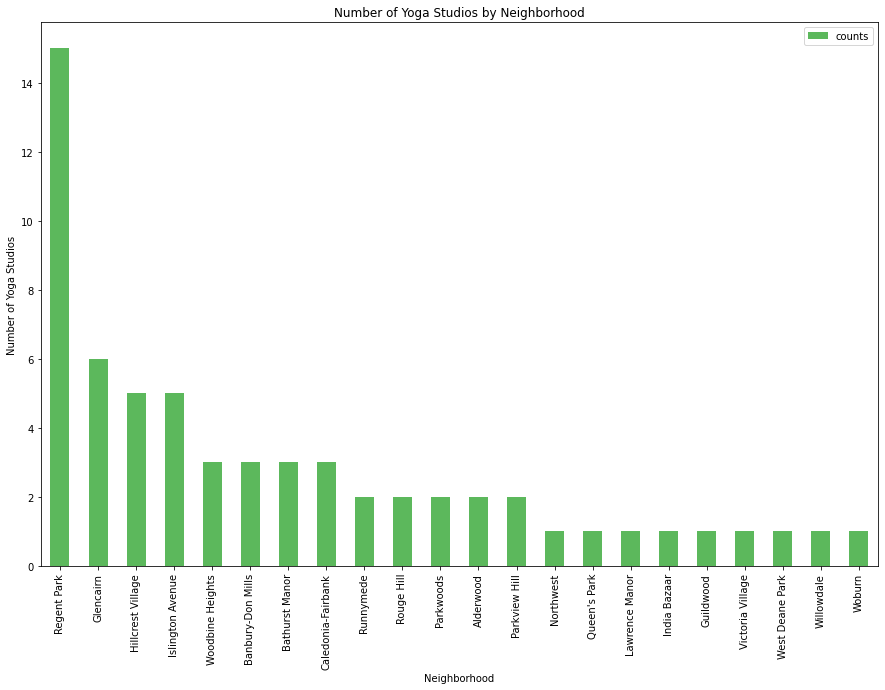

In [111]:
# step 2: plot data
countbyneigh.plot(kind='bar', 
                  color='#5cb85c',
                  figsize=(15, 10))

plt.xlabel('Neighborhood') 
plt.ylabel('Number of Yoga Studios') 
plt.title('Number of Yoga Studios by Neighborhood') 

plt.show()

### Many Yoga Studios are surrounded by Coffee Shops

In [162]:
byvenue = surrounding_venues.drop(['Neighborhood','Yoga Place','Yoga Place Latitude','Yoga Place Longitude','Venue','Venue Latitude','Venue Longitude' ], axis = 1)
byvenue= byvenue.groupby(['Venue Category']).size().reset_index(name='Total Venues')

In [163]:
byvenue = byvenue.sort_values(['Total Venues'], ascending = False,ignore_index=True)
byvenue = byvenue.set_index(['Venue Category'])

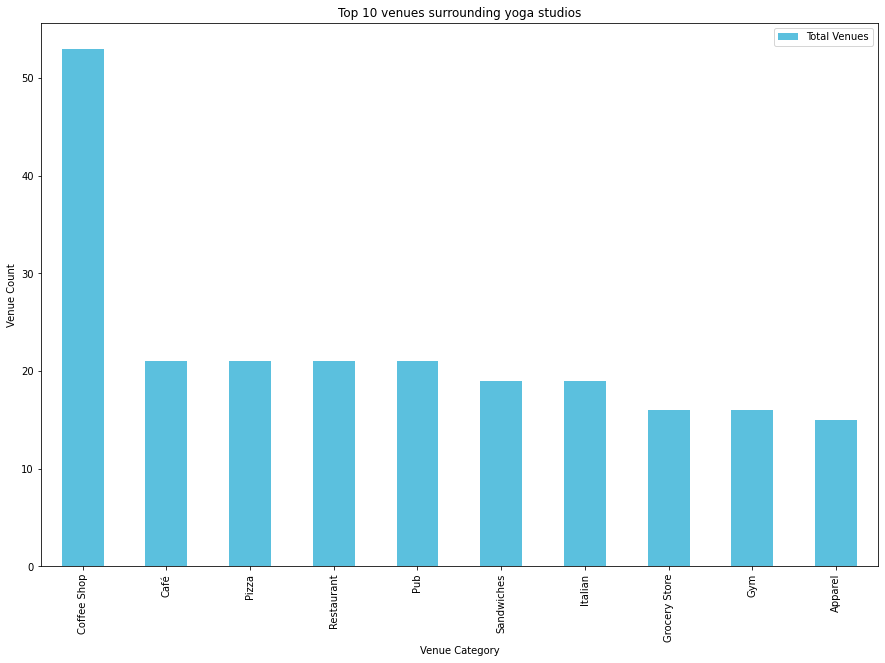

In [164]:
# step 2: plot data
byvenue.head(10).plot(kind='bar',
                      color='#5bc0de',
                  figsize=(15, 10))

plt.xlabel('Venue Category') 
plt.ylabel('Venue Count') 
plt.title('Top 10 venues surrounding yoga studios') 

plt.show()

Thank you for reviewing my notebook! :)